In [1]:
import os, sys
sys.path.append('../src/')

import seaborn as sns

from scipy import interpolate
from copulae1 import *

import json
with open('../src/configs/BBT_future_Tiingo_xrp_MM.json','r') as file:
    config = json.load(file)
config
data_name = config['data_name']
calibration_method  = config['calibration_method']
OHR = pd.read_hdf('../results/'+data_name +'/'+calibration_method+'/best_h.h5')
if not os.path.exists("../results/" + data_name + "/MLE/reports"):
	print("Create new folder for results")
	os.mkdir("../results/" + data_name + "/MLE/reports")
	os.mkdir("../results/" + data_name + "/MM/reports")
    
if calibration_method == "MLE":
    report_path = "../results/" + data_name + "/MLE/reports/"
    result_path = "../results/" + data_name + "/MLE/"
elif calibration_method == "MM":
    report_path = "../results/" + data_name + "/MM/reports/"
    result_path = "../results/" + data_name + "/MM/"

In [2]:
OHR = pd.read_csv("../results/%s/%s/OHR.csv"%(data_name, calibration_method))
cleaned_data = pd.read_csv('../data/cleaned_data/BBT_future_Tiingo_xrp.csv')

In [3]:
norm = stats.norm(0,1)

In [4]:
rs_law = stats.norm(scale = .1)
rf_law = stats.norm(scale = .5)
C = Gaussian({'rho':0.8}, Law_RS=rs_law, Law_RF=rf_law)

C.f_RH(0.7, -1.33)

6.587616138636955e-06

In [5]:
f_RH_vecfn = np.vectorize(lambda x: C.f_RH(0.7, x))

In [7]:
u_arr = np.linspace(0.01,.99,2000)
v_arr = np.linspace(0.01,.99,2000)

# C.c(u_arr,v_arr)
c_vecfn = np.vectorize(C.c)

In [18]:
def f(z, h):
    u_arr = np.linspace(0.01,.99,1000)
    helper = (rs_law.ppf(u_arr)-z)/h
    part1 = c_vecfn(rf_law.cdf(helper), u_arr)
    part2 = rf_law.pdf(helper)
    return np.sum(((part1*part2)[1:]+(part1*part2)[:-1])*(.98/1000)/2)

In [28]:
%%time
for i in range(len(z_arr)):
    print(f(z_arr[i], 0.1))

2.484480148670607e-09
5.576376682732222e-05
0.016067393075173707
0.19299303331637885
0.5251060923177373
0.5251060923177373
0.19299303331637851
0.016067393075173644
5.576376682732202e-05
2.4844801486705976e-09
CPU times: user 5.13 s, sys: 76.5 ms, total: 5.21 s
Wall time: 5.18 s


In [19]:
f_vecfn = np.vectorize(f)

In [30]:
%%time
z_arr = np.linspace(-0.3,0.3,10)
f_vecfn(z_arr, 0.1)

CPU times: user 5.17 s, sys: 26.1 ms, total: 5.19 s
Wall time: 5.2 s


array([2.48448015e-09, 5.57637668e-05, 1.60673931e-02, 1.92993033e-01,
       5.25106092e-01, 5.25106092e-01, 1.92993033e-01, 1.60673931e-02,
       5.57637668e-05, 2.48448015e-09])

In [35]:
%%time
c_vecfn(u_arr, v_arr)*rf_law.pdf(v_arr)

CPU times: user 981 ms, sys: 5.68 ms, total: 986 ms
Wall time: 987 ms


array([14.73345392, 14.19652741, 13.70315252, ...,  1.93778948,
        2.00362565,  2.07533105])

In [28]:
%%time
for i in range(len(u_arr)):
    print(C.c(u_arr[i], v_arr[i]))

18.469339586606722
4.792893522738821
3.1945087657542346
2.5433367845444934
2.1912926374127415
1.9762980071641867
1.8379620842612758
1.7488391882661218
1.695121421399795
1.6697693726855682
1.6697693726855682
1.695121421399795
1.7488391882661223
1.837962084261275
1.9762980071641867
2.1912926374127415
2.5433367845444934
3.194508765754232
4.792893522738818
18.469339586606722
CPU times: user 20.1 ms, sys: 4.69 ms, total: 24.8 ms
Wall time: 22.2 ms


In [10]:
rh_arr = np.linspace(-.1,.1,100)
f_arr = []
for i, rh in enumerate(rh_arr):
    print(i)
    f_arr.append(C.f_RH(.9, rh))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


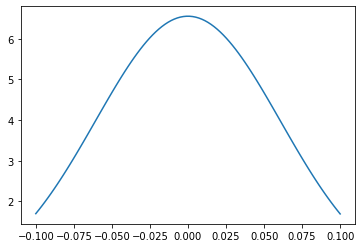

In [11]:
plt.plot(rh_arr, f_arr)

In [6]:
%%time
h = 1

# M = 1600
# N = 1600 # n points for integration

M = 1+2**10
N = 1+2**10
print(M, N)

u = np.linspace(0.000001,0.999999,N)
u_mat = np.repeat([u], M, axis=0)

y_left  = -0.4
y_right = .4
y_range = y_right - y_left

y = np.linspace(y_left,y_right,M)
y_mat = np.repeat(y.reshape((-1,1)), N, axis=1)

arg1 = norm.ppf(u_mat).reshape(-1)
# arg2 = norm.ppf(rf_law.cdf((rs_law.ppf(u) - y).reshape(-1))/h)

_h = (rs_law.ppf(u_mat) - y_mat)/h
arg2 = rf_law.cdf(_h) 
arg2[arg2 <= 0.000001] = 0.000001
arg2[arg2 >= 0.999999] = 0.999999
arg2 = norm.ppf(arg2).reshape(-1)

arg = np.stack((arg1, arg2), axis=-1)

part1 = (MN.pdf(arg)/(norm.pdf(arg1)*norm.pdf(arg2))).reshape(M,N) # copula density
part2 = rf_law.pdf(_h)

_int = (part1*part2)
# print(_int.shape)

# pdf = (_int[:,1:]+_int[:, :-1])*(1/N)/2
# pdf = np.sum(pdf, axis=1)/h

pdf = integrate.simps(_int, u, axis=1)/np.abs(h)

pdf_fn = interpolate.interp1d(y,pdf,kind='cubic', assume_sorted=True, fill_value="extrapolate")
cdf = np.cumsum(pdf)/np.sum(pdf)
cdf_fn = interpolate.interp1d(y,cdf,kind='cubic', fill_value="extrapolate")

# duplicate_id = (cdf[1:]-cdf[:-1])!=0
# ppf_fn = interpolate.interp1d(cdf[1:][duplicate_id], y[1:][duplicate_id], kind='cubic', fill_value='extrapolate')

ppf_fn = interpolate.interp1d(cdf, y, kind='cubic', fill_value='extrapolate')


VaR5 = -ppf_fn(0.05)
q_arr = np.linspace(0,0.05, 10000)
ES5 = -integrate.simps(ppf_fn(q_arr), q_arr)


print(integrate.simps(pdf,y), cdf[-1])

1025 1025


NameError: name 'MN' is not defined

In [7]:
ES5

NameError: name 'ES5' is not defined

In [8]:
VaR5

NameError: name 'VaR5' is not defined

In [9]:
plt.plot(y, pdf)

NameError: name 'pdf' is not defined

In [10]:
plt.plot(y, cdf)

NameError: name 'cdf' is not defined

In [11]:

q_arr = np.linspace(0,1, 10000)
plt.plot(q_arr,ppf_fn(q_arr))

NameError: name 'ppf_fn' is not defined

In [12]:
# plt.plot(y, pdf_fn(y))

plt.figure(figsize=(16,9))
plt.plot(y, pdf)

plt.xlim((-0.4,-0))
# x_arr = np.linspace(-0.4,-0.25, 10000)

# plt.plot(x_arr, pdf_fn(x_arr))

plt.scatter(-0.33,C.f_RH(h, -0.33))
plt.scatter(-0.34,C.f_RH(h, -0.34))
plt.scatter(-0.26,C.f_RH(h, -0.26))
plt.scatter(-0.15,C.f_RH(h, -0.15))

plt.scatter(0,C.f_RH(0.7, 0))

# plt.ylim((0,))

NameError: name 'pdf' is not defined

<Figure size 1152x648 with 0 Axes>

In [13]:
from scipy.stats import multivariate_normal
from scipy import integrate
rho = 0.8

R = np.array([[1.0, rho], [rho, 1]])
MN = multivariate_normal([0, 0], R)


In [14]:
# np.sum((pdf[1:]+ pdf[:-1])*(y_range/M)/2)
integrate.simps(pdf,y)

NameError: name 'pdf' is not defined

In [15]:
alpha = int(np.floor(0.05*len(y)))
integrate.simps(pdf,y)

NameError: name 'pdf' is not defined

In [16]:
cdf

NameError: name 'cdf' is not defined

In [17]:
MN_rvs = MN.rvs(10000)

u1 = norm.cdf(MN_rvs[:,0])
u2 = norm.cdf(MN_rvs[:,1])

rs = rs_law.ppf(u1)
rf = rf_law.ppf(u2)

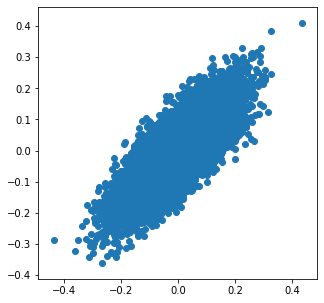

In [18]:
plt.figure(figsize=(5,5))
# plt.scatter(u1, u2)
plt.scatter(rs, rf)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-pack

NameError: name 'pdf_fn' is not defined

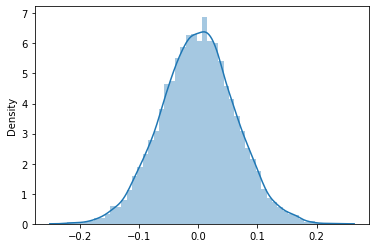

In [19]:
rh = rs-h*rf
sns.distplot(rh)
# plt.plot(y,pdf)
plt.plot(y,pdf_fn(y))

plt.xlim((0.1,0.3))
plt.ylim((0,0.1))

NameError: name 'cdf' is not defined

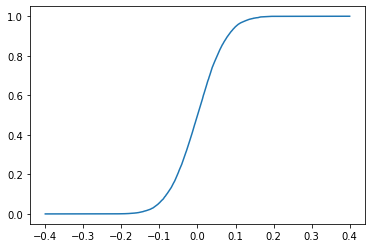

In [20]:
from statsmodels.distributions.empirical_distribution import ECDF

plt.plot(y, ECDF(rh)(y))
plt.plot(y, cdf)

In [45]:
file =  pd.read_csv('../processed_data/BBT_future_CRIX/train/0.csv')

In [47]:
# u = ECDF(file.iloc[:,-1])(file.iloc[:,-1])
# v = ECDF(file.iloc[:,-2])(file.iloc[:,-2])


# pd.DataFrame({'u':u, 'v':v}).to_csv('BBT_future_CRIX_0_uv.csv')
file.head()

,Unnamed: 0,Date,PX_LAST,contract_name,CRIX Price,log return future,log return CRIX
0,5,2021-05-20 20:00:00+00:00,40350.0,BTCM1 Curncy,4387.153184,0.021291,0.033315
1,6,2021-05-19 20:00:00+00:00,39500.0,BTCM1 Curncy,4243.404629,-0.090465,-0.157294
2,7,2021-05-18 20:00:00+00:00,43240.0,BTCM1 Curncy,4966.222392,-0.019694,-0.012067
3,8,2021-05-17 20:00:00+00:00,44100.0,BTCM1 Curncy,5026.514496,-0.131645,-0.123533
4,9,2021-05-14 20:00:00+00:00,50305.0,BTCM1 Curncy,5687.439512,0.036850,0.054760


In [48]:
sys.path.append('../../src/')

from KDEs import *
np.random.seed(0)

rs = file.iloc[:,-1]
rf = file.iloc[:,-2]

kde_rs = KDE(rs, 'Gaussian')
kde_rf = KDE(rf, 'Gaussian')

In [52]:
u = kde_rs.cdf(rs)
v = kde_rf.cdf(rf)


In [53]:
np.sum(v==0)

0

In [54]:
C = t_Copula({'rho':.1, 'nu':2}, kde_rs, kde_rf, 2)
C.mm_calibrate(u,v,[0.05,0.1, 0.9,0.95])

Optimization terminated successfully.
         Current function value: 0.024195
         Iterations: 174
         Function evaluations: 323


array([0.98449141, 2.        ])

In [55]:
C.l_fn(C.rho, C.nu,  u, v)

472.6304858759661

In [43]:
optimize_h(C, [10], [0.01,0.05], [0.01,0.05])

Optimization terminated successfully.
         Current function value: 0.000040
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.008517
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.026025
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.013982
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.016058
         Iterations: 11
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.008155
         Iterations: 11
         Function evaluations: 22


[0.9626953125,
 0.96708984375,
 0.97939453125,
 0.9743164062499999,
 0.982421875,
 0.955859375]